<a href="https://colab.research.google.com/github/raulbenitez/IWANN21/blob/main/MNIST_interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

batch_size = 128
num_classes = 10
epochs = 5

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax', name='preds'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [162]:
# Create the model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax', name='pred'))

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

batch_size = 250
no_epochs = 1
# Fit data to model
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=no_epochs)

score = model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')



240/240 [==============================] - 36s 146ms/step - loss: 0.2585 - accuracy: 0.9268
Test loss: 0.09228898584842682 / Test accuracy: 0.9731000065803528


In [163]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               1384704   
_________________________________________________________________
pred (Dense)                 (None, 10)                2570      
Total params: 1,387,594
Trainable params: 1,387,594
Non-trainable params: 0
____________________________________________

Model summary

Save the weights

In [164]:
model.save('/content/drive/MyDrive/DL_IWANN_data/MNIST_model_interpretability')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DL_IWANN_data/MNIST_model_interpretability/assets


Load the saved model

In [3]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/drive/MyDrive/DL_IWANN_data/MNIST_model_interpretability')

Check dimensions of all convolutional layers in the architecture

In [4]:
for layer in model.layers:
	if 'conv' not in layer.name:
		continue
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

conv2d_7 (3, 3, 1, 32)


## Visualize filters weights

In [5]:
filters, biases = model.layers[0].get_weights()
from matplotlib import pyplot

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

filters.shape
filters1 = filters.squeeze()

In the first convolutional layer there are 32 filters, each of size 3x3


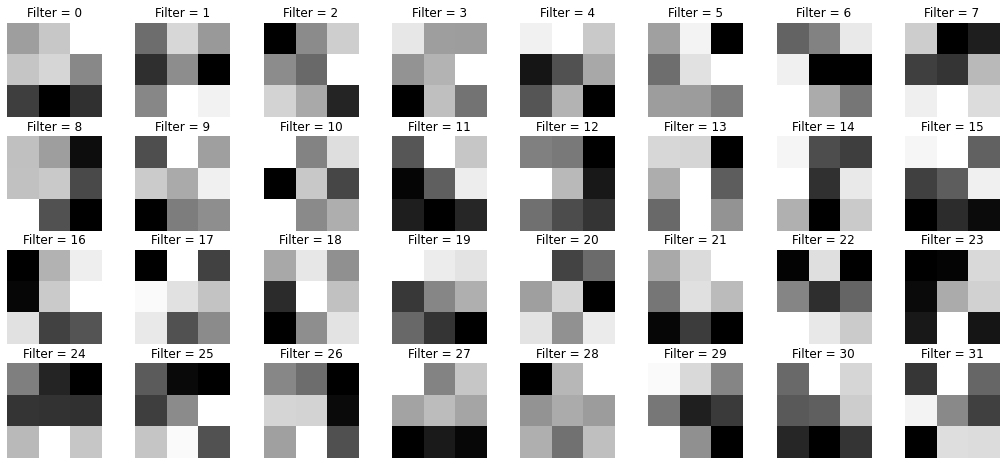

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 8))
for kfilt in range(0,32):
    ax = fig.add_subplot(4, 8, kfilt+1)
    ax.imshow(filters1[:,:,kfilt], cmap='gray') 
    ax.set_title('Filter = {}'.format(kfilt))
    ax.axis('off')

## Vizualize the feature maps 

Feature maps are the result of projecting an inpunt image across the different convolutional filters in the convolutional layers of the CNN.

In [10]:
from tensorflow.keras.models import Model

# define a new model with outputs the first layer
model_feat_layer0  = Model(inputs=model.inputs, outputs=model.layers[0].output)
model_feat_layer0.summary()

# extract the features provided by the model of the test input
feat_test_layer0 = model_feat_layer0.predict(x_test)

print('layer 0 shape {}'.format(feat_test_layer0.shape))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7_input (InputLayer)  [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________
layer 0 shape (10000, 26, 26, 32)


plot the feature maps corresponding to the first image in the test subset, which in this case corresponds to a

In [11]:
np.argmax(y_test[0])

7

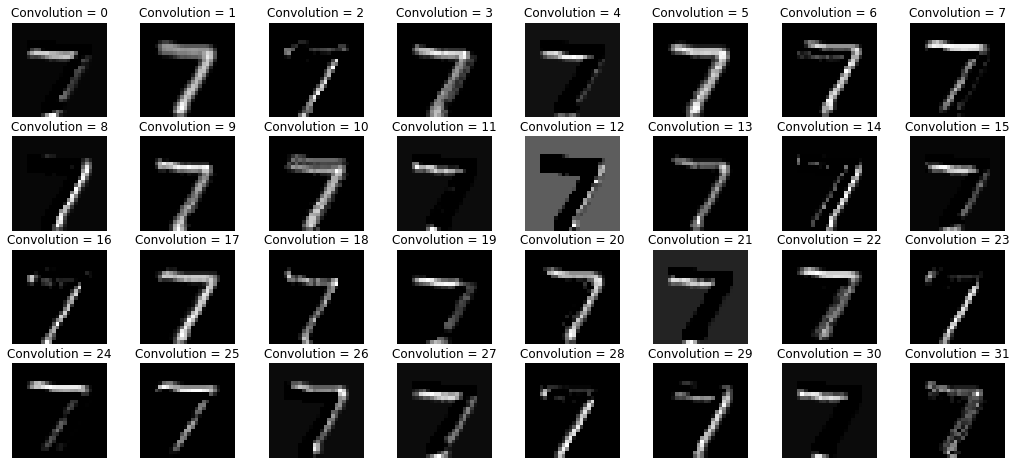

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 8))
for kfeat in range(0,32):
    ax = fig.add_subplot(4, 8, kfeat+1)
    ax.imshow(feat_test_layer0[0,:,:,kfeat], cmap='gray') 
    ax.set_title('Convolution = {}'.format(kfeat))
    ax.axis('off')

## Activation Maximization

https://raghakot.github.io/keras-vis/visualizations/activation_maximization/

Generate an input image that maximizes the filter output activations. i.e., we compute

$\frac{\partial ActivationMaximizationLoss}{\partial input}$ 

and use that estimate to update the input. ActivationMaximization loss simply outputs small values for large filter activations (we are minimizing losses during gradient descent iterations). This allows us to understand what sort of input patterns activate a particular filter. For example, there could be an eye filter that activates for the presence of eye within the input image.

In [14]:
!pip install tf-keras-vis

Change final activation layer from softmax to linear.
To compute the gradients, it is recommended to change the softmax activation function by
a linear function, since with the softmax the maximization of a class can be achieved by
minimising the scores of the other classes, and using a linear function we ensure that the
optimization concentrates only on the class in question.

In [15]:
from tf_keras_vis.activation_maximization import ActivationMaximization

def model_modifier(current_model):
    current_model.layers[-1].activation = tf.keras.activations.linear
    return current_model

activation_maximization = ActivationMaximization(model,
                                                 model_modifier,
                                                 clone=False)

Score function to maximize a certain category

In [16]:
from tf_keras_vis.utils.scores import CategoricalScore

class_score = 4
score = CategoricalScore(class_score)

In [17]:
from tf_keras_vis.activation_maximization.callbacks import PrintLogger as Logger
from tf_keras_vis.activation_maximization.callbacks import GifGenerator2D

# Generate maximized activation
activations = activation_maximization(score,callbacks=[Logger(interval=50)])

Steps: 050	Scores: [[-1059.9434814453125]],	Regularizations: [('TotalVariation2D', [9.7372407913208]), ('Norm', [3.6106507778167725])]
Steps: 100	Scores: [[-825.5335083007812]],	Regularizations: [('TotalVariation2D', [8.76260757446289]), ('Norm', [2.7576277256011963])]
Steps: 150	Scores: [[-387.7267761230469]],	Regularizations: [('TotalVariation2D', [13.967904090881348]), ('Norm', [1.9261133670806885])]
Steps: 200	Scores: [[-154.92822265625]],	Regularizations: [('TotalVariation2D', [9.79117488861084]), ('Norm', [1.1379616260528564])]


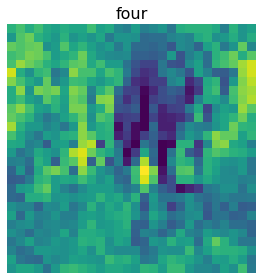

In [18]:
# Visualize 
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

f, ax = plt.subplots(figsize=(4, 4))
ax.imshow(activations.squeeze())
ax.set_title(class_names[class_score], fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

Steps: 050	Scores: [[38.28389358520508]],	Regularizations: [('TotalVariation2D', [10.126806259155273]), ('Norm', [4.275981903076172])]
Steps: 100	Scores: [[-95.20890808105469]],	Regularizations: [('TotalVariation2D', [10.110061645507812]), ('Norm', [3.9862935543060303])]
Steps: 150	Scores: [[93.81599426269531]],	Regularizations: [('TotalVariation2D', [9.814332962036133]), ('Norm', [3.7382447719573975])]
Steps: 200	Scores: [[310.0873718261719]],	Regularizations: [('TotalVariation2D', [12.053145408630371]), ('Norm', [3.504166841506958])]
Steps: 050	Scores: [[-488.204833984375]],	Regularizations: [('TotalVariation2D', [8.5881929397583]), ('Norm', [4.407853126525879])]
Steps: 100	Scores: [[-329.3826599121094]],	Regularizations: [('TotalVariation2D', [7.879638195037842]), ('Norm', [4.344766616821289])]
Steps: 150	Scores: [[-434.4541015625]],	Regularizations: [('TotalVariation2D', [9.509746551513672]), ('Norm', [4.313152313232422])]
Steps: 200	Scores: [[-440.41339111328125]],	Regularizations

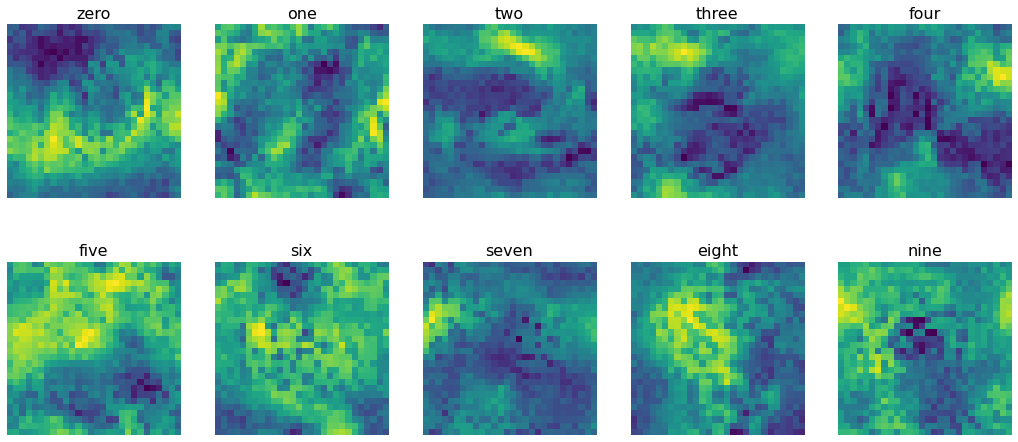

In [19]:
fig = plt.figure(figsize=(18, 8))
for kclass in range(0,10):
    score = CategoricalScore(kclass)
    activation_maximization = ActivationMaximization(model,model_modifier,clone=False)
    activations = activation_maximization(score,callbacks=[Logger(interval=50)])
    ax = fig.add_subplot(2, 5, kclass+1)
    ax.imshow(activations.squeeze())
    ax.set_title(class_names[kclass], fontsize=16)
    ax.axis('off')

# Attention maps: Saliency & GradCAM

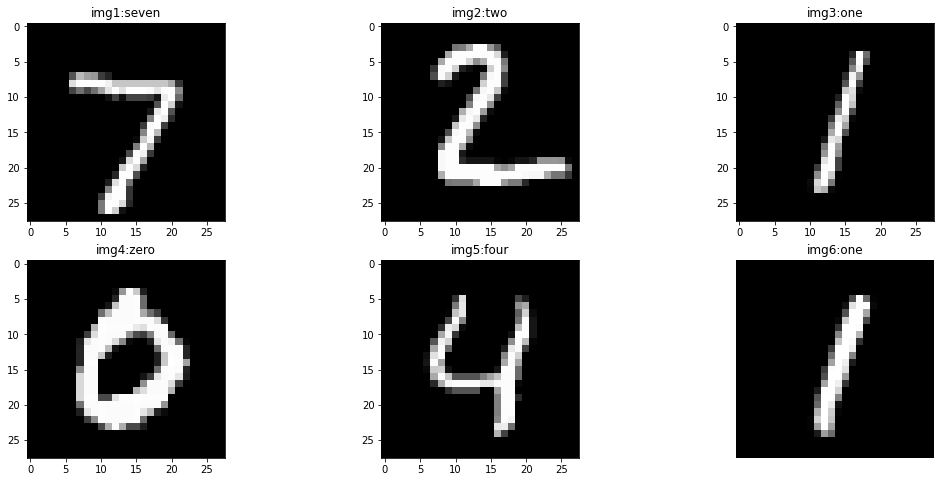

In [53]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input

# Image titles
image_titles = ['seven', 'two', 'one','zero','four','one']

# Load images and Convert them to a Numpy array
img1 = x_test[0].reshape(28,28)
img2 = x_test[1].reshape(28,28)
img3 = x_test[2].reshape(28,28)
img4 = x_test[3].reshape(28,28)
img5 = x_test[4].reshape(28,28)
img6 = x_test[5].reshape(28,28)

fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(2, 3, 1)
ax.imshow(img1, cmap='gray') 
ax.set_title('img1:'+ image_titles[0])
ax = fig.add_subplot(2, 3, 2)
ax.imshow(img2, cmap='gray') 
ax.set_title('img2:'+ image_titles[1])
ax = fig.add_subplot(2,3, 3)
ax.imshow(img3, cmap='gray') 
ax.set_title('img3:' + image_titles[2])
ax = fig.add_subplot(2,3, 4)
ax.imshow(img4, cmap='gray') 
ax.set_title('img4:' + image_titles[3])
ax = fig.add_subplot(2,3, 5)
ax.imshow(img5, cmap='gray') 
ax.set_title('img5:' + image_titles[4])
ax = fig.add_subplot(2,3, 6)
ax.imshow(img6, cmap='gray') 
ax.set_title('img6:' + image_titles[5])
ax.axis('off')
plt.show()



## GradCam

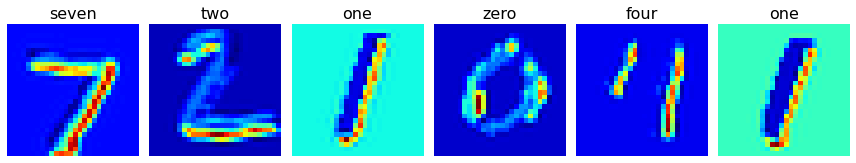

In [69]:
images = np.asarray([np.array(img1), np.array(img2), np.array(img3),np.array(img4),np.array(img5),np.array(img6)])
X = images.reshape(6,28,28,1)

score = CategoricalScore([7, 2, 1, 0, 4, 1])

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=model_modifier,
                  clone=False)

# Generate heatmap with GradCAM
cam = gradcam(score, X, penultimate_layer=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=6, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    #ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=1) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()


## GradCam++

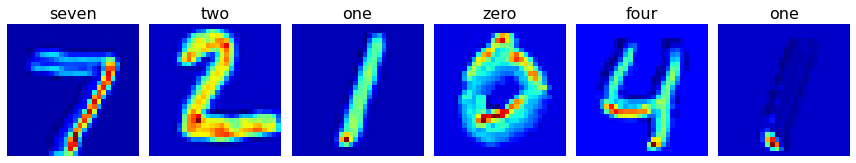

In [68]:
from tf_keras_vis.gradcam import GradcamPlusPlus

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam++ object

# Create GradCAM++ object and repalce class name to "GradcamPlusPlus"
gradcamplus = GradcamPlusPlus(model,
                          model_modifier,
                          clone=False)

# Generate heatmap with GradCAM
camplus = gradcamplus(score, X, penultimate_layer=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=6, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(camplus[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    #ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=1) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()



## LIME

Local Interpretable Model-agnostic Explanations (LIME) is a revolutionary method
proposed in 2016 to explain the predictions of any classifier in a faithful way, by
approximating it locally with an interpretable model. The method is called model-agnostic
because it is able to explain any model, treating it as a black box and using only its inputs
and outputs.

In [63]:
!pip install lime

     |████████████████████████████████| 276kB 2.9MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283858 sha256=56195c3e6ee37727c8950f4722fb8458da2429791ec3faa2d853a2921526694e
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [66]:
from Lime.lime import lime_image
from keras.models import load_model
from skimage.segmentation import mark_boundaries, quickshift, slic, felzenszwalb

image = img1
superpixels = quickshift(image, ratio=0.2, kernel_size=6, max_dist=200)
num_superpixels = np.unique(superpixels).shape[0]
print('Number of superpixels: ' + str(num_superpixels))
def segmentation_algorithm(img):
#superpixels = slic(img_proc, n_segments=30, compactness=50, sigma=1)
#superpixels = quickshift(image, ratio=0.2, kernel_size=6, max_dist=200)
  superpixels = felzenszwalb(image, scale=200, sigma=1, min_size=200)
  return superpixels

seg_alg = segmentation_algorithm
explainer = lime_image.LimeImageExplainer(verbose=True, feature_selection = 'lasso_path', random_state=454)
explanation = explainer.explain_instance(image, model.predict, top_labels=1, hide_color=167, num_samples=500,num_features=num_superpixels,segmentation_fn=seg_alg, random_seed=42)
print('\n--------------------------------------------')
print('\nNombre de superpixels: %d' % len(np.unique(explanation.segments)))
print('Labels ordenats: %s' % explanation.top_labels)
print('Score: %f' % explanation.score)
num_features=5
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False,
num_features=num_features, hide_rest=True)
fig, ax = plt.subplots(1,2, figsize=(8,8))
ax[0].imshow(image)
ax[1].imshow(image)
ax[1].imshow(mask, cmap='viridis', alpha=0.7)

ModuleNotFoundError: ignored